In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# others
from funciones_limpieza import *
from utils_aprendizaje_no_supervisado import * 
from funciones_clasificacion import *
from funciones_seriestemporales import *

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#import os
#os.chdir('/content/drive/MyDrive/RandomForest')

In [ ]:
#pip install neuralsens

In [2]:
#Calcular métricas a partir de matriz acumulada
def resumen_metricas_desde_cm(cm):
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    total = TP + TN + FP + FN
    acc = (TP + TN) / total
    sens = TP / (TP + FN) if (TP + FN) != 0 else 0
    spec = TN / (TN + FP) if (TN + FP) != 0 else 0
    prec = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = sens
    f1 = 2 * (prec * recall) / (prec + recall) if (prec + recall) != 0 else 0
    bal_acc = (sens + spec) / 2

    print(f"Accuracy: {acc:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {spec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Balanced Accuracy: {bal_acc:.2f}") #A diferencia del accuracy tradicional, que puede ser engañosamente alto si una clase domina, la balanced accuracy da un peso igual a cada clase, evaluando el desempeño del modelo en cada una por separado y luego promediando.

# Carga de los csvs y preprocesado

In [3]:
# ---------------------
# 1. Definir carpetas
# ---------------------
carpeta_myrtle = "./Join_plots_alarmas"
carpeta_sigma = "./Join_plots_alarmas_Sigma"

# ---------------------
# 2. Obtener lista de CSVs
# ---------------------
archivos = []
for carpeta in [carpeta_myrtle, carpeta_sigma]:
    archivos += [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith(".csv")]

print(f"Total de archivos (inversores): {len(archivos)}")

# ---------------------
# 3. Leer y unir todos 
# ---------------------
dfs_global = []
for f in archivos:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    df['Condensacion'] = df['Condensacion'].astype('category')
    dfs_global.append(df)

df_global = pd.concat(dfs_global, ignore_index=True)

print(f"Shape del DataFrame global: {df_global.shape}")
print(df_global[['inversor_id']].value_counts())  # Ver cuantos registros por inversor




Total de archivos (inversores): 72
Shape del DataFrame global: (3110328, 47)
inversor_id 
10.144.51.1     86398
10.144.51.15    86398
10.144.51.52    43199
10.144.51.58    43199
10.144.51.57    43199
                ...  
10.144.51.38    43199
10.144.51.39    43199
10.144.51.40    43199
10.144.51.41    43199
F1              43199
Name: count, Length: 70, dtype: int64


In [3]:
#CADA FILA DEL DATAFRAME DE LOS INVERSORES ES UNA MUESTRA PARA EL MODELO

In [4]:
# Define input and output matrices
variables = df_global.columns.to_list()
INPUTS = [var for var in variables if var != 'Condensacion']
OUTPUT = 'Condensacion'
X = df_global[INPUTS]
y = df_global[OUTPUT]

In [5]:
y_inversores = [] #será una lista de tamaño 72 cada elemento será 1 o 0 dependiendo del valor que tenga la columna 'Condensación'

for f in archivos:
    df = pd.read_csv(f)
    if df['Condensacion'].unique() == 1:
        y_inversores.append(1)
    else:
        y_inversores.append(0)

In [6]:
len(y_inversores)

72

In [7]:
# ---------------------
# División en train y test por inversor
# ---------------------
archivos_train, archivos_test = train_test_split(archivos,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify = y_inversores) #preserva la distribución de y (proporción de 1 y 0)

dfs_train = []
for f in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_train.append(df)

dfs_test = []
for f in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_test.append(df)

df_train_total = pd.concat(dfs_train, ignore_index=True)
df_test_total = pd.concat(dfs_test, ignore_index=True)

print("Inversores en train:", len(dfs_train))
print("Inversores en test:", len(dfs_test))
print("Shape train:", df_train_total.shape)
print("Shape test:", df_test_total.shape)

Inversores en train: 57
Inversores en test: 15
Shape train: (2462343, 47)
Shape test: (647985, 47)


In [8]:
#Localizamos los inversores con fallo de condensación tanto en train como test
condensacion_test = []
for archivo in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_test_total[df_test_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_test.append(df_inv)
        print(f'El inversor {nombre_inversor} de test ha tenido fallo de condensación')

condensacion_train = []
for archivo in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_train_total[df_train_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_train.append(df_inv)
        print(f'El inversor {nombre_inversor} de train ha tenido fallo de condensación')

El inversor 10.144.51.56 de test ha tenido fallo de condensación
El inversor 10.144.51.51 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.29 de train ha tenido fallo de condensación
El inversor F1 de train ha tenido fallo de condensación


In [9]:
X_train = df_train_total[INPUTS]
y_train = df_train_total[OUTPUT]
X_test = df_test_total[INPUTS]
y_test = df_test_total[OUTPUT]

In [10]:
#ELIMINAR FechaHora (PUES LA INFO HORARIA LA TENGO EN utc)

# Eliminar la columna original
X_train = X_train.drop(columns=['FechaHora'])
X_test = X_test.drop(columns=['FechaHora'])

# Añadir nuevas columnas a INPUTS_DT si las quieres usar
#INPUTS += ['hora', 'minuto']
INPUTS.remove('FechaHora')

# DecisionTree con variables ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

In [11]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity

In [12]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
#param = {'DT__min_impurity_decrease': [0.02]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='recall')

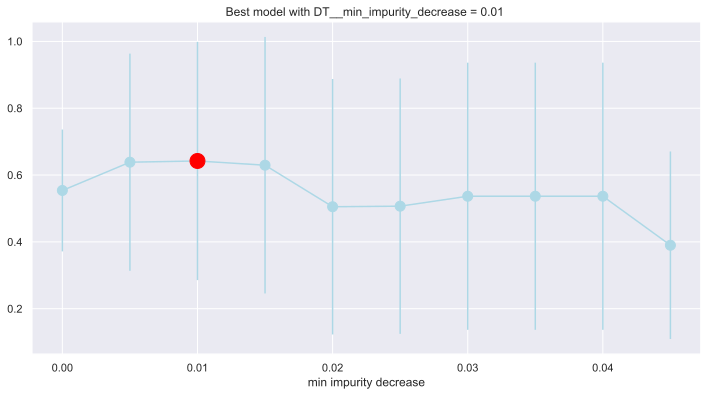

In [13]:
plotModelGridError(tree_fit)
#El eje y de las gráficas que genera esta función representa el mean_test_score, es decir: El promedio del score de validación cruzada para
#cada combinación de hiperparámetros evaluada en el GridSearchCV. En nuestro caso scoring='accuracy', el eje y mostrará la precisión promedio
#que tuvo el modelo en los distintos folds para cada parámetro.

#También hay barras de error que muestran la desviación estándar (std_test_score) para esa métrica, reflejando la variabilidad del desempeño.

#

In [12]:
#Entrenamos el modelo con el mejor hiperparámetro según el score 'recall'
#INPUTS_DT = ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']
#modelo_dt = DecisionTreeClassifier(
#    criterion='gini',               
#    min_samples_split=5,            
#    min_samples_leaf=5,
#    class_weight='balanced',        
#    min_impurity_decrease=0.01,    
#    random_state=150
#)

# Entrenar el modelo con TODO el conjunto de entrenamiento
#modelo_dt.fit(X_train[INPUTS_DT], y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.01,
                       min_samples_leaf=5, min_samples_split=5,
                       random_state=150)

In [14]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = ['T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']

#param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
param = {'DT__min_impurity_decrease': [0.01]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1, param_grid={'DT__min_impurity_decrease': [0.01]},
             scoring='recall')

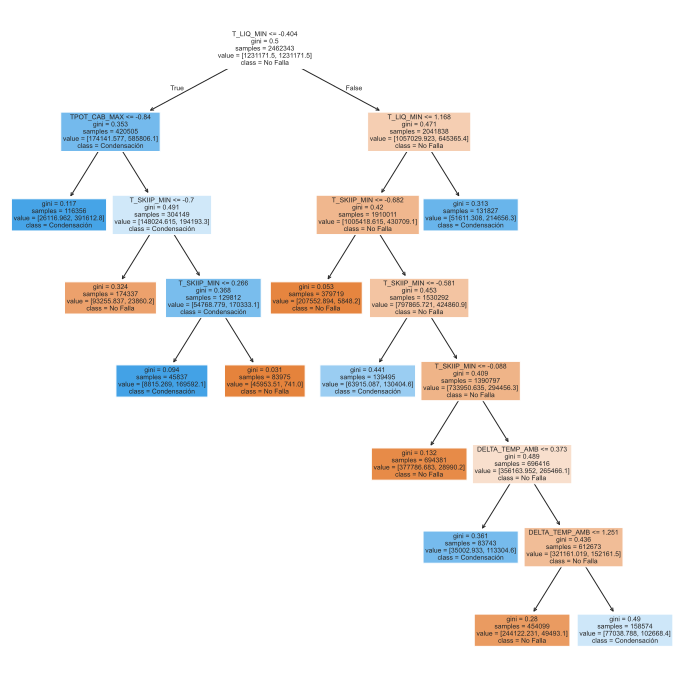

In [15]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'],
          filled=True,
          feature_names=INPUTS_DT,  # para que aparezcan los nombres de las variables y no x[0], x[1],...
          class_names=['No Falla', 'Condensación'])  # 0 es 'No falla' y 1 es 'Condensación'
plt.savefig('./img_DT/DecisionTree4_EsquemaArbol.png')
plt.show()

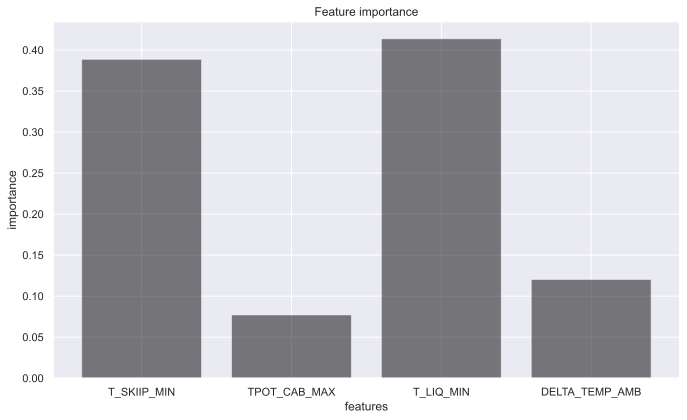

In [16]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.savefig('./img_DT/DecisionTree4_ImportanciaVariables.png')
plt.show()

#La variable que más se ha tenido en cuenta a la hora de realizar el árbol es T_LIQ_MIN
#En un árbol de decisión, la importancia de una variable se calcula como: La suma del descenso en la impureza (por ejemplo, Gini o la entropía)
#causado por esa variable en cada nodo donde se usa.

#Fórmula general: Para una variable 𝑥𝑗, su importancia es:
#Importancia(𝑥𝑗) = ∑(nodos donde se usa 𝑥𝑗) 𝑁nodo / 𝑁total ⋅ Δimpureza
#Δimpureza: reducción de impureza (como Gini o Entropía) en el nodo cuando se hace el split.
#𝑁nodo: número de muestras en el nodo.
#𝑁total: número total de muestras en el árbol.
#Después, se normaliza para que todas las importancias sumen 1.

In [17]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data (TRAIN)
dfTR_eval.head()

,utc,sample,PPC_PMG,PPC_QMG,PMG_M,QMG_M,UL1_RMS,UL2_RMS,UL3_RMS,IT1_RMS,...,DPF_TEMP_INT,T_SKIIP_MIN,TPOT_CAB_MAX,T_LIQ_MIN,DELTA_TEMP_AMB,inversor_id,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
0,1741109376,1438019,318000.0,-283000.0,1053600.875,-282928.25000,391.576508,393.663177,393.294800,917.239807,...,0.0,45.548550,37.533852,43.761784,8.014698,10.144.51.52,0,0,0.928732,0.071268
1,1741109378,1438020,318000.0,-283000.0,1052255.375,-283148.12500,392.713287,393.099640,392.691559,917.814697,...,0.0,45.417213,37.533852,43.761784,7.883361,10.144.51.52,0,0,0.928732,0.071268
2,1741109380,1438021,318000.0,-283000.0,1051038.375,-283066.96875,392.693237,392.986084,392.677795,917.794250,...,0.0,45.507092,37.533852,43.761784,7.973240,10.144.51.52,0,0,0.928732,0.071268
3,1741109382,1438022,318000.0,-283000.0,1049642.500,-283017.06250,391.531189,393.664001,393.281830,914.290344,...,0.0,45.296680,37.533852,43.761784,7.762828,10.144.51.52,0,0,0.928732,0.071268
4,1741109384,1438023,318000.0,-283000.0,1047860.125,-283144.31250,392.756775,393.069977,392.799438,914.266357,...,0.0,45.411793,37.533852,43.761784,7.877941,10.144.51.52,0,0,0.928732,0.071268


In [18]:
#visualize evaluated data (TEST)
dfTS_eval.head()

,utc,sample,PPC_PMG,PPC_QMG,PMG_M,QMG_M,UL1_RMS,UL2_RMS,UL3_RMS,IT1_RMS,...,DPF_TEMP_INT,T_SKIIP_MIN,TPOT_CAB_MAX,T_LIQ_MIN,DELTA_TEMP_AMB,inversor_id,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
0,1741110431,926014,804000.0,-298000.0,484716.43750,-297896.06250,392.322144,391.865936,392.275604,480.999084,...,0.0,47.881428,30.703094,43.775841,17.178334,10.144.51.73,0,0,0.928732,0.071268
1,1741110433,926015,804000.0,-298000.0,483588.68750,-298155.75000,392.296906,391.811646,392.278503,479.944031,...,0.0,47.772987,30.703093,43.775841,17.069894,10.144.51.73,0,0,0.928732,0.071268
2,1741110435,926016,804000.0,-298000.0,484016.59375,-297675.93750,392.246246,391.827484,392.273773,478.255737,...,0.0,47.997082,30.703093,43.775841,17.293989,10.144.51.73,0,0,0.928732,0.071268
3,1741110437,926017,798000.0,-298000.0,483015.09375,-297802.65625,392.341156,391.879852,392.336914,477.764618,...,0.0,47.899445,30.703093,43.775841,17.196352,10.144.51.73,0,0,0.928732,0.071268
4,1741110439,926018,798000.0,-298000.0,480651.40625,-298127.00000,392.224792,391.699432,392.207031,477.876740,...,0.0,47.667854,30.703093,43.775841,16.964761,10.144.51.73,0,0,0.928732,0.071268


In [19]:
#Ahora vamos a ver las predicciones del modelo para el inversor 10.144.51.56 del conjunto de test
inv101445156 = df_test_total[df_test_total['inversor_id'] == '10.144.51.56']
inv101445156_X = inv101445156[INPUTS]
inv101445156_y = inv101445156[OUTPUT]

inv101445156_eval = inv101445156_X.copy()
inv101445156_eval['Y'] = inv101445156_y
inv101445156_eval['Y_DT_pred'] = tree_fit.predict(inv101445156_X[INPUTS_DT])
inv101445156_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(inv101445156_X[INPUTS_DT])[:,0]
inv101445156_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(inv101445156_X[INPUTS_DT])[:,1]
inv101445156_eval = inv101445156_eval.sort_values(by='utc')
inv101445156_eval

,utc,sample,PPC_PMG,PPC_QMG,PMG_M,QMG_M,UL1_RMS,UL2_RMS,UL3_RMS,IT1_RMS,...,DPF_TEMP_INT,T_SKIIP_MIN,TPOT_CAB_MAX,T_LIQ_MIN,DELTA_TEMP_AMB,inversor_id,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
561587,1741071445,3646371,1209000.0,-277000.0,8.941011e+05,-277178.968750,391.733093,392.161804,392.269623,790.993347,...,0.0,49.699020,34.447857,43.962357,15.251163,10.144.51.56,1,1,0.236016,0.763984
561588,1741071447,3646372,1203000.0,-277000.0,8.920621e+05,-277008.343750,390.725555,392.864807,393.020874,786.274475,...,0.0,49.818020,34.447857,43.962357,15.370163,10.144.51.56,1,1,0.236016,0.763984
561589,1741071449,3646373,1203000.0,-277000.0,8.906611e+05,-276981.843750,390.900452,393.154968,393.127533,784.829224,...,0.0,49.747215,34.447857,43.962357,15.299358,10.144.51.56,1,1,0.236016,0.763984
561590,1741071451,3646374,1203000.0,-277000.0,8.886239e+05,-276897.625000,390.921722,393.178009,393.073700,783.154541,...,0.0,49.700779,34.447857,43.962357,15.252922,10.144.51.56,1,1,0.236016,0.763984
561591,1741071453,3646375,1203000.0,-277000.0,8.873054e+05,-277062.437500,392.045135,392.548187,392.409851,784.099548,...,0.0,49.677895,34.447857,43.962357,15.230038,10.144.51.56,1,1,0.236016,0.763984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604781,1741157837,3689565,2240000.0,-152000.0,1.341281e+06,-152333.843750,398.444977,399.346893,396.056824,1123.863525,...,0.0,51.206520,31.445141,44.264633,19.761379,10.144.51.56,1,0,0.831436,0.168564
604782,1741157839,3689566,2242000.0,-152000.0,1.339428e+06,-152314.843750,398.530670,399.381958,396.035461,1122.322388,...,0.0,51.138798,31.445141,44.264633,19.693657,10.144.51.56,1,0,0.831436,0.168564
604783,1741157841,3689567,2246000.0,-152000.0,1.336376e+06,-152217.671875,397.340088,399.925995,396.664459,1117.134033,...,0.0,51.309574,31.144882,43.962357,20.164692,10.144.51.56,1,0,0.831436,0.168564
604784,1741157843,3689568,2239000.0,-152000.0,1.333418e+06,-152157.140625,397.327820,399.916107,396.660645,1114.856812,...,0.0,51.063473,31.144882,43.962357,19.918591,10.144.51.56,1,0,0.831436,0.168564


In [20]:
#Vamos a ver cuales son las filas que ha clasificado mal:
inv101445156_eval_bienClasificados = inv101445156_eval[inv101445156_eval['Y'] == inv101445156_eval['Y_DT_pred']]
print(f'El modelo ha clasificado correctamente {len(inv101445156_eval_bienClasificados)} registros')
inv101445156_eval_malClasificados = inv101445156_eval[inv101445156_eval['Y'] != inv101445156_eval['Y_DT_pred']]
print(f'El modelo ha clasificado incorrectamente {len(inv101445156_eval_malClasificados)} registros')

El modelo ha clasificado correctamente 3442 registros
El modelo ha clasificado incorrectamente 39757 registros


In [21]:
#Veamos en qué rango se encuentran las muestras mal clasificadas
inicio = inv101445156_eval_malClasificados['FechaHora'].min()
fin = inv101445156_eval_malClasificados['FechaHora'].max()
print(f"Rango horario: {inicio} a {fin}")

#EN ESTE INVERSOR LA ALARMA 721 SALTÓ A LAS 2025/03/05 09:59:38

KeyError: 'FechaHora'

In [22]:
# Predicciones en train y test
y_train_pred = tree_fit.predict(X_train[INPUTS_DT])
y_test_pred = tree_fit.predict(X_test[INPUTS_DT])

# Función para calcular specificity (sensibilidad de la clase negativa)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels = [0,1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Métricas en train
acc_train = accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
#specificity_train = specificity_score(y_train, y_train_pred)
#f1_train = f1_score(y_train, y_train_pred)

# Métricas en test
acc_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
#specificity_test = specificity_score(y_test, y_test_pred)
#f1_test = f1_score(y_test, y_test_pred)

print("TRAIN METRICS:")
print(f"Accuracy: {acc_train:.4f}")
print(f"Recall: {recall_train:.4f}")
#print(f"Specificity: {specificity_train:.4f}")
#print(f"F1-score: {f1_train:.4f}\n")

print("TEST METRICS:")
print(f"Accuracy: {acc_test:.4f}")
print(f"Recall: {recall_test:.4f}")
#print(f"Specificity: {specificity_test:.4f}")
#print(f"F1-score: {f1_test:.4f}")

TRAIN METRICS:
Accuracy: 0.7977
Recall: 0.9115
TEST METRICS:
Accuracy: 0.6905
Recall: 0.0797


In [66]:
# Predicciones
#y_pred_train = tree_fit.predict(X_train[INPUTS_DT])

# Matriz de confusión
#cm_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1])
#print(cm_train)

In [67]:
#Matriz de confusión de test
#confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'], labels=[0,1])

In [23]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TRAIN) --> 4 variables

y_pred_train = dfTR_eval['Y_DT_pred']

# Luego el mismo procedimiento por batches:
batch_size = 100_000
conf_matrix_total_train = np.array([[0, 0], [0, 0]])

for i in range(0, len(y_train), batch_size):
    y_true_batch = y_train[i:i + batch_size]
    y_pred_batch = y_pred_train[i:i + batch_size]
    
    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_train += cm_batch

# Mismas métricas
resumen_metricas_desde_cm(conf_matrix_total_train)


Accuracy: 0.80
Recall (Sensitivity): 0.91
Specificity: 0.79
Precision: 0.29
F1 Score: 0.44
Balanced Accuracy: 0.85


In [24]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TEST) -> 4 variables

batch_size = 100_000
conf_matrix_total = np.array([[0, 0], [0, 0]])
y_true = dfTS_eval['Y'].values
y_pred = dfTS_eval['Y_DT_pred'].values


#Acumular matriz de confusión por lotes
for i in range(0, len(y_true), batch_size):
    y_true_batch = y_true[i:i + batch_size]
    y_pred_batch = y_pred[i:i + batch_size]
    
    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total += cm_batch

resumen_metricas_desde_cm(conf_matrix_total)

#ESTAS MÉTRICAS SON BASTANTE PEORES QUE LAS DE TRAIN POR LO QUE PUEDE HABER OVEERFITTING

Accuracy: 0.69
Recall (Sensitivity): 0.08
Specificity: 0.73
Precision: 0.02
F1 Score: 0.03
Balanced Accuracy: 0.41


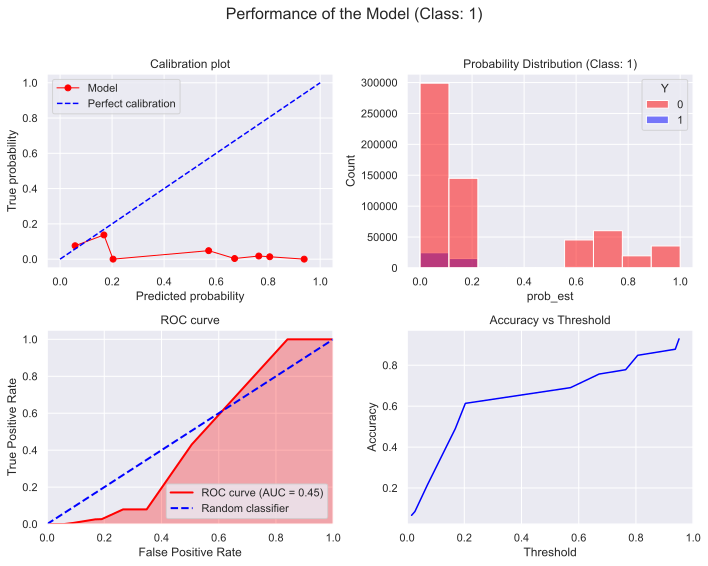

In [25]:
plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=1)

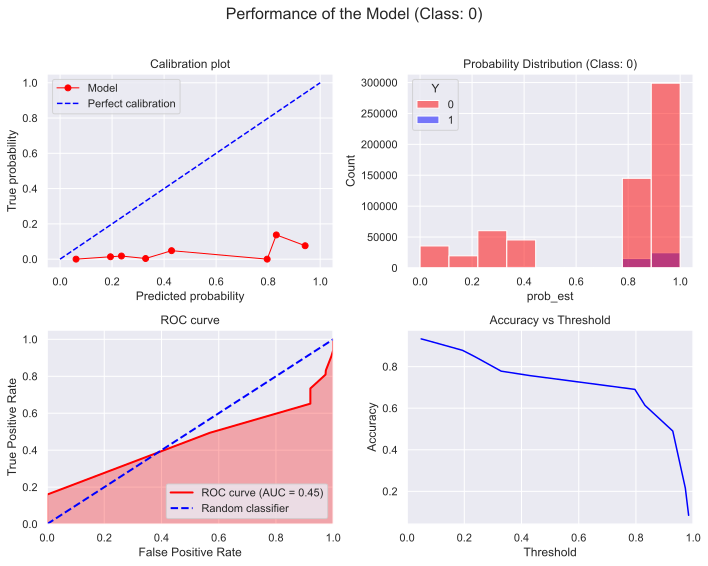

In [26]:
plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=0)

In [10]:
## Create dataset to store model predictions
dfTR_eval_all = X_train.copy()
dfTR_eval_all['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval_all = X_test.copy()
dfTS_eval_all['Y'] = y_test # We will call Y as output variable for simplicity

In [32]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = INPUTS

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
#param = {'DT__min_impurity_decrease': [0.02]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit_all = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit_all.fit(X_train[INPUTS_DT], y_train) # Search in grid

Process LokyProcess-5:
Exception ignored in: <finalize object at 0x15e343e80; dead>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tfm/lib/python3.11/weakref.py", line 585, in __call__
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plotModelGridError(tree_fit)

In [11]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = INPUTS

#param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
param = {'DT__min_impurity_decrease': [0.01]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid


KeyboardInterrupt



# Decision tree con 2 PCA

In [27]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num = X_train_num.drop(columns=['sample'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test_num.drop(columns=['sample'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [28]:
X_train_num.columns

Index(['utc', 'PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS',
       'UL3_RMS', 'IT1_RMS', 'IT2_RMS', 'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL',
       'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU', 'TEXTERIOR', 'TCAB_AC',
       'TCAB_POT1', 'TCAB_POT2', 'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13',
       'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1',
       'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET',
       'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT', 'T_SKIIP_MIN',
       'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB'],
      dtype='object')

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Información sobre PCA

In [31]:
# Obtener los loadings de cada variable original en cada componente
loadings = pd.DataFrame(
    pca.components_.T,  # transponemos para tener variables como filas
    columns=[f'PCA_{i+1}' for i in range(pca.n_components_)],
    index=X_train_num.columns  # nombres originales de las variables numéricas
)

In [32]:
# Mostrar las 10 variables que más aportan (por valor absoluto del loading) a cada componente
for i in range(pca.n_components_):
    print(f"\n🔹 PCA_{i+1} - Top 10 variables más influyentes:")
    display(
        loadings.iloc[:, i]
        .abs()  # tomamos valor absoluto
        .sort_values(ascending=False)
        .head(10)
    )



🔹 PCA_1 - Top 10 variables más influyentes:


TBRID12        0.216356
TBRID23        0.215984
TBRID22        0.215800
TBRID21        0.215595
T_SKIIP_MIN    0.214793
TBRID11        0.214127
TBRID13        0.213993
TCOILIND1      0.211089
TCOILIND2      0.208470
IT2_RMS        0.207843
Name: PCA_1, dtype: float64


🔹 PCA_2 - Top 10 variables más influyentes:


TCAB_POT1         0.369014
TSOC              0.366726
TCCU              0.336449
TPOT_CAB_MAX      0.326475
TCAB_POT2         0.288796
TAIR_INLET        0.268655
DELTA_TEMP_AMB    0.247186
TDC_FUSES         0.203348
UL3_RMS           0.187054
TCOOLINGI         0.169812
Name: PCA_2, dtype: float64

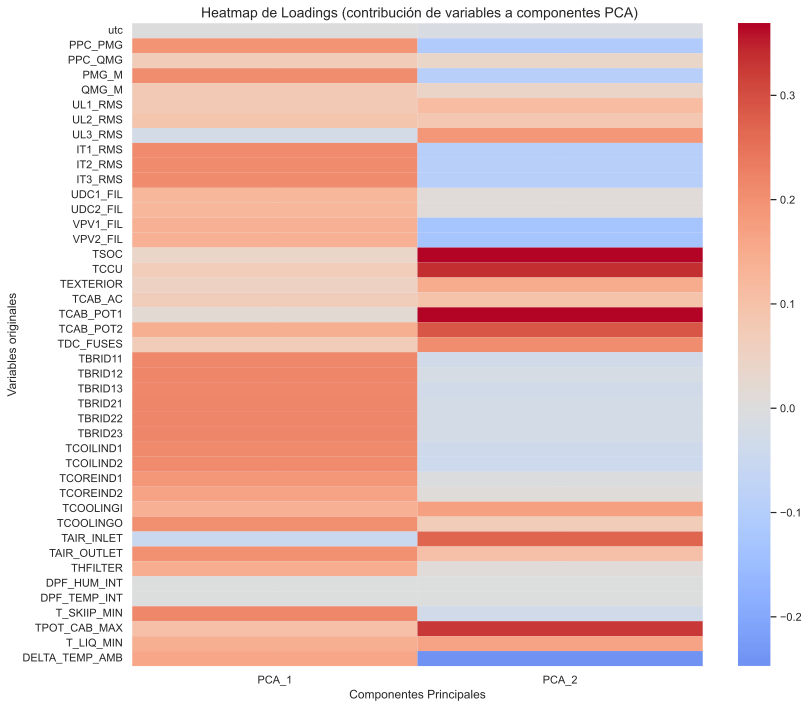

In [33]:
plt.figure(figsize=(12, 10))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False)
plt.title(" Heatmap de Loadings (contribución de variables a componentes PCA)", fontsize=14)
plt.xlabel("Componentes Principales")
plt.ylabel("Variables originales")
plt.tight_layout()
plt.savefig('./img_DT/DecisionTreePCA_HeatMapLoadings.png')
plt.show()

### Entreno Decision Tree

In [34]:
#Vamos a convertir los arrays resultantes de la PCA en un dataframe

X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(X_test_pca.shape[1])])

In [35]:
X_train_pca.columns.to_list()

['PCA_1', 'PCA_2']

In [36]:
## Create dataset to store model predictions
dfTR_eval_pca = X_train_pca.copy()
dfTR_eval_pca['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval_pca = X_test_pca.copy()
dfTS_eval_pca['Y'] = y_test # We will call Y as output variable for simplicity

In [37]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = X_train_pca.columns.to_list()

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
#param = {'DT__min_impurity_decrease': [0.02]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit_pca = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit_pca.fit(X_train_pca[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='recall')

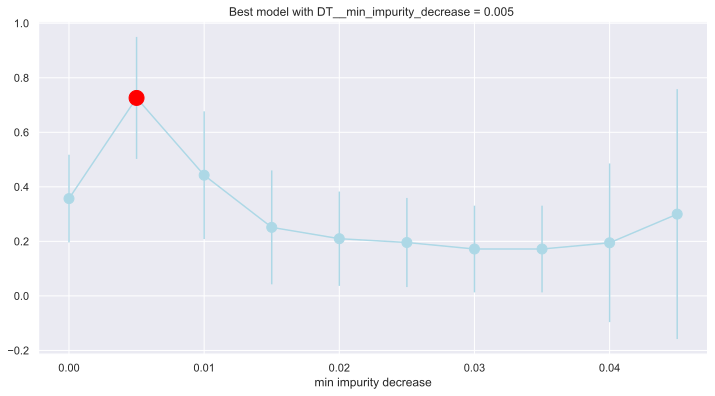

In [38]:
plotModelGridError(tree_fit_pca)

In [39]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = X_train_pca.columns.to_list()

#param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.  
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
param = {'DT__min_impurity_decrease': [0.005]} # Minimum entropy to decrease in each split 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     class_weight='balanced',
                                                     random_state=150))]) #me crea una semilla (así las componentes aleatorias serán siempre las mismas al ejecutar esa semilla)

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit_pca = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='recall', #Debido al desbalanceo de clases se escoge recall
                       cv=nFolds) # Number of Folds 
tree_fit_pca.fit(X_train_pca[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1, param_grid={'DT__min_impurity_decrease': [0.005]},
             scoring='recall')

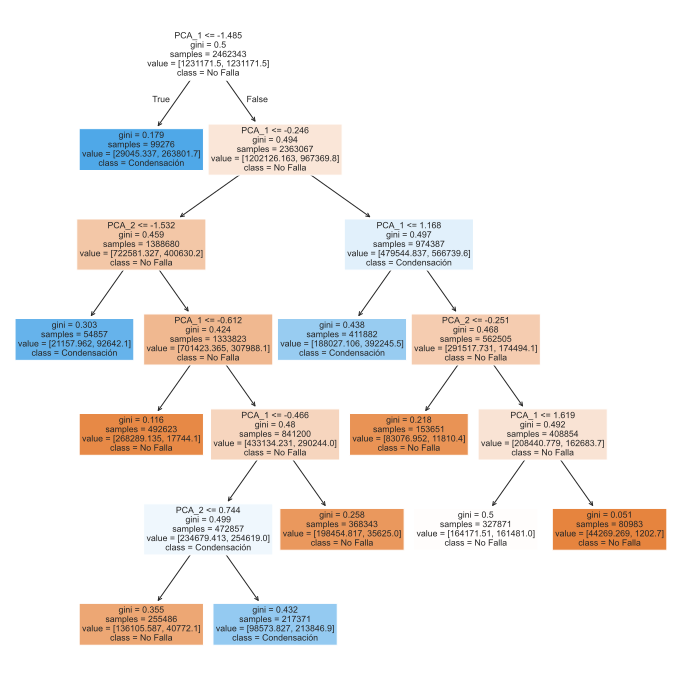

In [40]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit_pca.best_estimator_['DT'],
          filled=True,
          feature_names=INPUTS_DT,  # para que aparezcan los nombres de las variables y no x[0], x[1],...
          class_names=['No Falla', 'Condensación'])  # 0 es 'No falla' y 1 es 'Condensación'
plt.savefig('./img_DT/PCADecisionTree_EsquemaArbol.png')
plt.show()

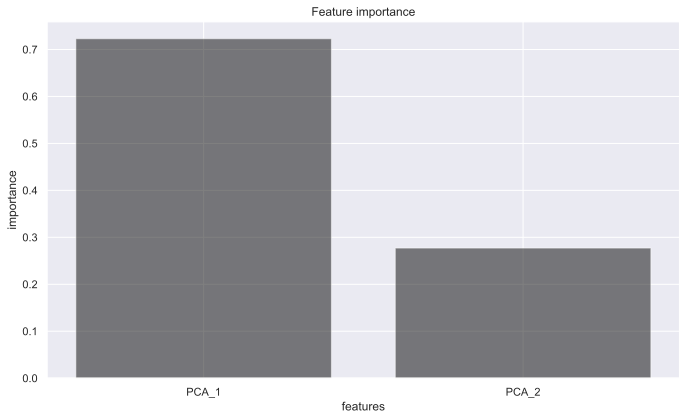

In [41]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train_pca[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit_pca.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train_pca[INPUTS_DT].columns)
plt.tight_layout()
plt.savefig('./img_DT/PCADecisionTree_ImportanciaVariables.png')
plt.show()

#La que más importancia tiene es PCA_3

In [42]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_pca['Y_DT_pred'] = tree_fit_pca.predict(X_train_pca[INPUTS_DT])
dfTR_eval_pca['Y_DT_prob_neg'] = tree_fit_pca.predict_proba(X_train_pca[INPUTS_DT])[:,0]
dfTR_eval_pca['Y_DT_prob_pos'] = tree_fit_pca.predict_proba(X_train_pca[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval_pca['Y_DT_pred'] = tree_fit_pca.predict(X_test_pca[INPUTS_DT])
dfTS_eval_pca['Y_DT_prob_neg'] = tree_fit_pca.predict_proba(X_test_pca[INPUTS_DT])[:,0]
dfTS_eval_pca['Y_DT_prob_pos'] = tree_fit_pca.predict_proba(X_test_pca[INPUTS_DT])[:,1]

#visualize evaluated data (TRAIN)
dfTR_eval_pca.head()

,PCA_1,PCA_2,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
0,0.409340,2.693039,0,1,0.324032,0.675968
1,0.426005,2.719566,0,1,0.324032,0.675968
2,0.439145,2.720397,0,1,0.324032,0.675968
3,0.391316,2.646029,0,1,0.324032,0.675968
4,0.418472,2.709643,0,1,0.324032,0.675968


In [43]:
#visualize evaluated data (TEST)
dfTS_eval_pca.head()

,PCA_1,PCA_2,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
0,-0.185550,0.252875,0,1,0.324032,0.675968
1,-0.193325,0.234579,0,1,0.324032,0.675968
2,-0.185043,0.282961,0,1,0.324032,0.675968
3,-0.208009,0.190975,0,1,0.324032,0.675968
4,-0.215993,0.287221,0,1,0.324032,0.675968


In [44]:
#Ahora vamos a ver las predicciones del modelo para el inversor 10.144.51.56 del conjunto de test
inv101445156 = df_test_total[df_test_total['inversor_id'] == '10.144.51.56']
inv101445156_X = inv101445156[INPUTS]
inv101445156_y = inv101445156[OUTPUT]
inv101445156_y = inv101445156_y.reset_index(drop=True)
#Aplicamos las transformaciones (StandardScaler y PCA)
inv101445156_X_num = inv101445156_X.select_dtypes(include=['int64', 'float64'])
inv101445156_X_num = inv101445156_X_num.drop(columns=['sample'])
inv101445156_X_scaled = scaler.transform(inv101445156_X_num)  # usa el mismo scaler
inv101445156_X_pca = pca.transform(inv101445156_X_scaled)           # usa la misma PCA
inv101445156_X_pca = pd.DataFrame(inv101445156_X_pca, columns=[f'PCA_{i+1}' for i in range(X_train_pca.shape[1])])

inv101445156_eval_pca = inv101445156_X_pca.copy()
inv101445156_eval_pca['Y'] = inv101445156_y
inv101445156_eval_pca['Y_DT_pred'] = tree_fit_pca.predict(inv101445156_X_pca[INPUTS_DT])
inv101445156_eval_pca['Y_DT_prob_neg'] = tree_fit_pca.predict_proba(inv101445156_X_pca[INPUTS_DT])[:,0]
inv101445156_eval_pca['Y_DT_prob_pos'] = tree_fit_pca.predict_proba(inv101445156_X_pca[INPUTS_DT])[:,1]
#inv101445156_eval_pca = inv101445156_eval_pca.sort_values(by='utc')
inv101445156_eval_pca

,PCA_1,PCA_2,Y,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
0,-0.053665,1.533149,1,1,0.324032,0.675968
1,-0.068283,1.484343,1,1,0.324032,0.675968
2,-0.066849,1.515909,1,1,0.324032,0.675968
3,-0.077529,1.460764,1,1,0.324032,0.675968
4,-0.054073,1.461920,1,1,0.324032,0.675968
...,...,...,...,...,...,...
43194,1.382424,-0.056228,1,1,0.324032,0.675968
43195,1.387405,-0.007129,1,1,0.324032,0.675968
43196,1.325621,-0.177196,1,1,0.324032,0.675968
43197,1.319620,-0.126812,1,1,0.324032,0.675968


In [45]:
#Vamos a ver cuales son las filas que ha clasificado mal:
inv101445156_eval_pca_bienClasificados = inv101445156_eval_pca[inv101445156_eval_pca['Y'] == inv101445156_eval_pca['Y_DT_pred']]
print(f'El modelo ha clasificado correctamente {len(inv101445156_eval_pca_bienClasificados)} registros')
inv101445156_eval_pca_malClasificados = inv101445156_eval_pca[inv101445156_eval_pca['Y'] != inv101445156_eval_pca['Y_DT_pred']]
print(f'El modelo ha clasificado incorrectamente {len(inv101445156_eval_pca_malClasificados)} registros')

El modelo ha clasificado correctamente 13184 registros
El modelo ha clasificado incorrectamente 30015 registros


In [46]:
# Predicciones en train y test
y_train_pred_pca = tree_fit_pca.predict(X_train_pca[INPUTS_DT])
y_test_pred_pca = tree_fit_pca.predict(X_test_pca[INPUTS_DT])

# Función para calcular specificity (sensibilidad de la clase negativa)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels = [0,1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Métricas en train
acc_train_pca = accuracy_score(y_train, y_train_pred_pca)
recall_train_pca = recall_score(y_train, y_train_pred_pca)
#specificity_train = specificity_score(y_train, y_train_pred)
#f1_train = f1_score(y_train, y_train_pred)

# Métricas en test
acc_test_pca = accuracy_score(y_test, y_test_pred_pca)
recall_test_pca = recall_score(y_test, y_test_pred_pca)
#specificity_test = specificity_score(y_test, y_test_pred)
#f1_test = f1_score(y_test, y_test_pred)

print("TRAIN METRICS:")
print(f"Accuracy: {acc_train_pca:.4f}")
print(f"Recall: {recall_train_pca:.4f}")
#print(f"Specificity: {specificity_train:.4f}")
#print(f"F1-score: {f1_train:.4f}\n")

print("TEST METRICS:")
print(f"Accuracy: {acc_test_pca:.4f}")
print(f"Recall: {recall_test_pca:.4f}")
#print(f"Specificity: {specificity_test:.4f}")
#print(f"F1-score: {f1_test:.4f}")

TRAIN METRICS:
Accuracy: 0.7313
Recall: 0.7818
TEST METRICS:
Accuracy: 0.6786
Recall: 0.3052


In [47]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TRAIN) -> PCA

y_pred_train_pca = dfTR_eval_pca['Y_DT_pred']

# Luego el mismo procedimiento por batches:
batch_size = 100_000
conf_matrix_total_train_pca = np.array([[0, 0], [0, 0]])

for i in range(0, len(y_train), batch_size):
    y_true_batch = y_train[i:i + batch_size]
    y_pred_batch = y_pred_train_pca[i:i + batch_size]
    
    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_train_pca += cm_batch

# Mismas métricas
resumen_metricas_desde_cm(conf_matrix_total_train_pca)

Accuracy: 0.73
Recall (Sensitivity): 0.78
Specificity: 0.73
Precision: 0.22
F1 Score: 0.34
Balanced Accuracy: 0.75


In [48]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TEST) -> PCA

batch_size = 100_000
conf_matrix_total_test_pca = np.array([[0, 0], [0, 0]])
y_true_pca = dfTS_eval_pca['Y'].values
y_pred_pca = dfTS_eval_pca['Y_DT_pred'].values


#Acumular matriz de confusión por lotes
for i in range(0, len(y_true_pca), batch_size):
    y_true_batch = y_true_pca[i:i + batch_size]
    y_pred_batch = y_pred_pca[i:i + batch_size]
    
    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_test_pca += cm_batch

resumen_metricas_desde_cm(conf_matrix_total_test_pca)

#ESTAS MÉTRICAS SON BASTANTE PEORES QUE LAS DE TRAIN POR LO QUE PUEDE HABER OVEERFITTING

Accuracy: 0.68
Recall (Sensitivity): 0.31
Specificity: 0.71
Precision: 0.07
F1 Score: 0.11
Balanced Accuracy: 0.51


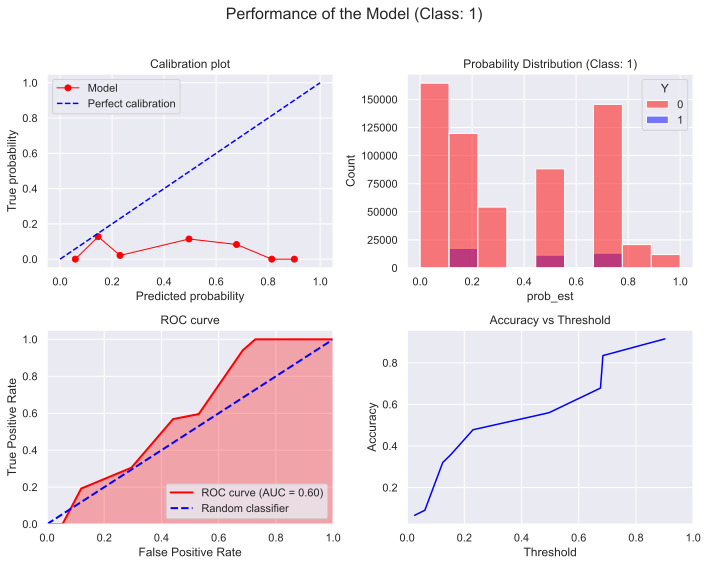

In [49]:
plotClassPerformance(dfTS_eval_pca['Y'], tree_fit_pca.predict_proba(X_test_pca[INPUTS_DT]), selClass=1)

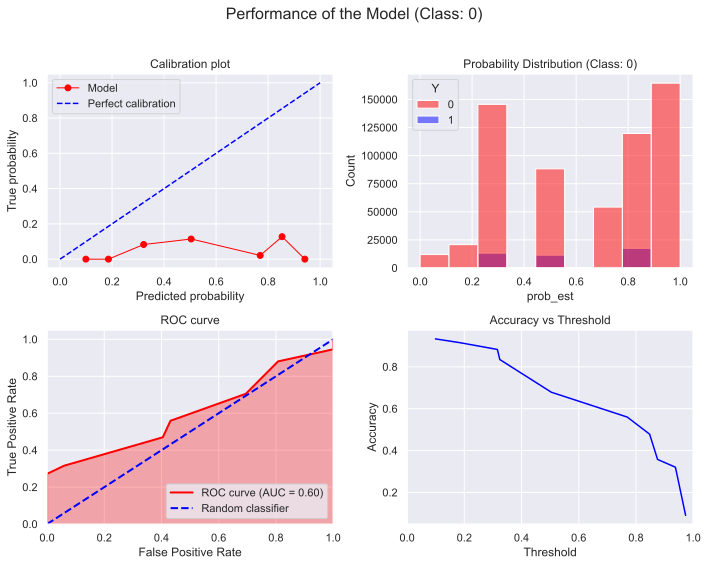

In [50]:
plotClassPerformance(dfTS_eval_pca['Y'], tree_fit_pca.predict_proba(X_test_pca[INPUTS_DT]), selClass=0)